## Parsing Objects and Walls Data

In [113]:
import json
import os
import pandas as pd
import numpy as np

In [114]:
data_path = r"C:\Users\ethan_haque\Desktop\tmp\walls_and_objects_data"

In [115]:
def get_json_files(path):
    json_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".json"):
                json_files.append(os.path.join(root, file))
    return json_files

In [116]:
objects_and_walls_via_json_file_paths = get_json_files(data_path)

In [117]:
def parse_via_json_file(via_json_file_path):
    with open(via_json_file_path, encoding="utf8") as f:
        data = json.load(f)

    return data["_via_img_metadata"]


In [118]:
def validate_dei_selections(image_id, image_info):
    dei_errors = []
    if "file_attributes" not in image_info:
        dei_errors.append({"image_id": image_id, "error": "No file attributes"})
        return dei_errors

    selections = image_info["file_attributes"]

    categories = set(selections["category"].keys())
    diversity_categories = set(selections["diversity category"].keys())
    identity_categories = set(selections["identity category"].keys())

    if (not categories) and (not diversity_categories) and (not identity_categories):
        dei_errors.append({"image_id": image_id, "error": "No categories, diversity categories, or identity categories"})
        return dei_errors
    if not categories:
        dei_errors.append({"image_id": image_id, "error": "No categories"})
    if not diversity_categories:
        dei_errors.append({"image_id": image_id, "error": "No diversity categories"})
    if not identity_categories:
        dei_errors.append({"image_id": image_id, "error": "No identity categories"})

    validate_none_category(image_id, categories, diversity_categories, identity_categories, dei_errors)
    validate_diversity_inclusion_category(image_id, categories, diversity_categories, dei_errors)
    validate_diversity_category(image_id, diversity_categories, identity_categories, dei_errors)

    return dei_errors


def validate_none_category(image_id, categories, diversity_categories, identity_categories, errors):
    if "none" in categories:
        if len(categories) > 1:
            errors.append({"image_id": image_id, "error": "Category 'none' and other categories"})
        if diversity_categories != {"NA"}:
            errors.append({"image_id": image_id, "error": "Category 'none' and diversity category not 'NA'"})
        if identity_categories != {"NA"}:
            errors.append({"image_id": image_id, "error": "Category 'none' and identity category not 'NA'"})


def validate_diversity_inclusion_category(image_id, categories, diversity_categories, errors):
    if "diversity and inclusion" in categories and diversity_categories == {"NA"}:
        errors.append({"image_id": image_id, "error": "Category 'diversity and inclusion' and diversity category 'NA'"})
    elif "diversity and inclusion" not in categories and diversity_categories != {"NA"}:
        errors.append(
            {"image_id": image_id, "error": "Category not 'diversity and inclusion' and diversity category not 'NA'"})


def validate_diversity_category(image_id, diversity_categories, identity_categories, errors):
    if "explicitly identity-affirming" in diversity_categories or "minority/marginalized representation" in diversity_categories:
        if identity_categories == {"NA"}:
            errors.append({"image_id": image_id, "error": "Diversity category not 'NA' and identity category 'NA'"})
    elif identity_categories != {"NA"}:
        errors.append({"image_id": image_id, "error": "Diversity category 'NA' and identity category not 'NA'"})


def create_one_hot_coding_labels(possible_categories, selected_categories):
    return [True if category in selected_categories else False for category in possible_categories]

def get_file_information(file_path):
    parent_dir = os.path.dirname(file_path)
    batch_name = "_".join(parent_dir.split(" ")[:-1]).split("\\")[-1].lower()
    batch_type = parent_dir.split(" ")[-1].lower()
    file_name = os.path.basename(file_path)
    ra_coder = os.path.dirname(parent_dir).split("\\")[-1].lower()

    return {"ra_coder": ra_coder, "batch_name": batch_name, "batch_type": batch_type, "json_file_path": file_path,
            "json_file_name": file_name}

In [119]:
# file_information = ["ra_coder", "batch_name", "batch_type", "json_file_path", "json_file_name"]
image_information = ["image_id", "error"]
category_information = ["indiscernible", "none", "diversity and inclusion", "majority/dominant representation",
                        "hate symbols", "sports", "sci fi", "other", "ambiguous"]
diversity_information = ["NA", "explicitly identity-affirming", "minority/marginalized representation",
                         "diversity/multiculturalism general", "belonging general", "other", "ambiguous"]
identity_information = ["NA", "bipoc", "non-cis man", "lgbq", "non-christian", "disability", "other", "ambiguous"]

category_information_with_prefix = ["category " + category for category in category_information]
diversity_information_with_prefix = ["diversity category " + diversity for diversity in diversity_information]
identity_information_with_prefix = ["identity category " + identity for identity in identity_information]

rows = []
for file_path in objects_and_walls_via_json_file_paths:
    via_image_data = parse_via_json_file(file_path)
    file_information = get_file_information(file_path)
    for img_id, img_info in via_image_data.items():
        dei_errors = validate_dei_selections(img_id, img_info)
        error_str = ""
        if dei_errors:
            error_str = "\n".join([error["error"] for error in dei_errors])

        selected_categories = list(img_info["file_attributes"]["category"].keys())
        selected_diversity_categories = list(img_info["file_attributes"]["diversity category"].keys())
        selected_identity_categories = list(img_info["file_attributes"]["identity category"].keys())

        one_hot_coding_categories = create_one_hot_coding_labels(category_information, selected_categories)
        one_hot_coding_diversity = create_one_hot_coding_labels(diversity_information, selected_diversity_categories)
        one_hot_coding_identity = create_one_hot_coding_labels(identity_information, selected_identity_categories)



        row = {"image_id": img_id, "error": error_str, **file_information,
               **dict(zip(category_information_with_prefix, one_hot_coding_categories)),
               **dict(zip(diversity_information_with_prefix, one_hot_coding_diversity)),
               **dict(zip(identity_information_with_prefix, one_hot_coding_identity))}

        rows.append(row)


In [120]:
object_wall_hanging_df = pd.DataFrame(rows)
object_wall_hanging_df.to_csv("../object_wall_hanging_report/object_wall_hanging_coding.csv", index=False)

In [121]:
object_wall_hanging_df

,image_id,error,ra_coder,batch_name,batch_type,json_file_path,json_file_name,category indiscernible,category none,category diversity and inclusion,...,diversity category other,diversity category ambiguous,identity category NA,identity category bipoc,identity category non-cis man,identity category lgbq,identity category non-christian,identity category disability,identity category other,identity category ambiguous
0,user43_242_poster-wall-hanging_5_5.jpg8143,,destiny,batch_100,walls,C:\Users\ethan_haque\Desktop\tmp\walls_and_obj...,Destiny Batch 100 Walls.json,False,False,True,...,False,False,False,True,True,False,False,False,False,False
1,user62_2825_poster-wall-hanging_7_6.jpg2806,,destiny,batch_100,walls,C:\Users\ethan_haque\Desktop\tmp\walls_and_obj...,Destiny Batch 100 Walls.json,False,True,False,...,False,False,True,False,False,False,False,False,False,False
2,user84_1627_poster-wall-hanging_2_1.jpg5716,,destiny,batch_100,walls,C:\Users\ethan_haque\Desktop\tmp\walls_and_obj...,Destiny Batch 100 Walls.json,False,False,True,...,False,False,False,False,True,False,False,False,False,False
3,user99_310_poster-wall-hanging_4_4.jpg16326,,destiny,batch_100,walls,C:\Users\ethan_haque\Desktop\tmp\walls_and_obj...,Destiny Batch 100 Walls.json,False,True,False,...,False,False,True,False,False,False,False,False,False,False
4,user106_345_poster-wall-hanging_4_4.jpg5008,,destiny,batch_100,walls,C:\Users\ethan_haque\Desktop\tmp\walls_and_obj...,Destiny Batch 100 Walls.json,False,False,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24008,user2904_2180_poster-wall-hanging_2_1.jpg13329,,stephanie,training_batch_4b,walls,C:\Users\ethan_haque\Desktop\tmp\walls_and_obj...,Stephanie 51 - 2962.json,False,True,False,...,False,False,True,False,False,False,False,False,False,False
24009,user2925_1559_poster-wall-hanging_6_7.jpg37962,,stephanie,training_batch_4b,walls,C:\Users\ethan_haque\Desktop\tmp\walls_and_obj...,Stephanie 51 - 2962.json,False,True,False,...,False,False,True,False,False,False,False,False,False,False
24010,user2933_1567_poster-wall-hanging_4_3.jpg12751,,stephanie,training_batch_4b,walls,C:\Users\ethan_haque\Desktop\tmp\walls_and_obj...,Stephanie 51 - 2962.json,False,True,False,...,False,False,True,False,False,False,False,False,False,False
24011,user2955_945_poster-wall-hanging_7_6.jpg4722,,stephanie,training_batch_4b,walls,C:\Users\ethan_haque\Desktop\tmp\walls_and_obj...,Stephanie 51 - 2962.json,False,True,False,...,False,False,True,False,False,False,False,False,False,False


## Visualizations

In [122]:
import seaborn as sns
sns.set_style("ticks")
sns.set(rc={"figure.figsize": (15, 7.5)})
sns.set(font_scale=1.25)

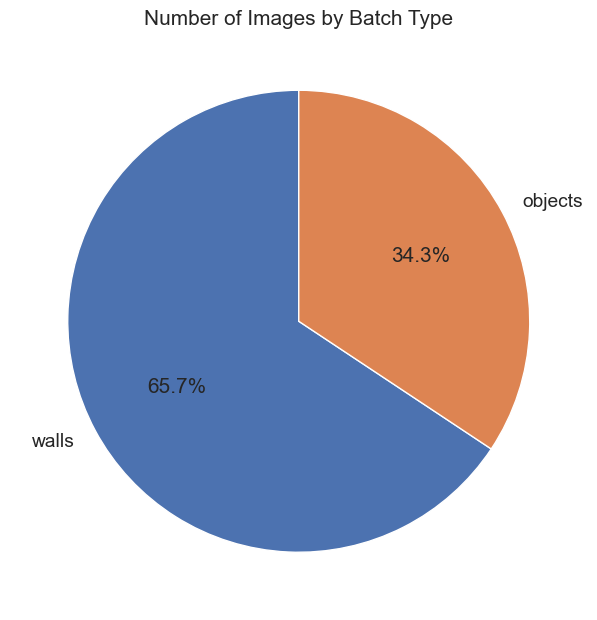

In [123]:
# plot and save image
images_by_batch_type = object_wall_hanging_df["batch_type"].value_counts().plot(kind="pie", autopct="%1.1f%%", startangle=90)
images_by_batch_type.set_title("Number of Images by Batch Type")
images_by_batch_type.set_ylabel("")
figure = images_by_batch_type.get_figure()
figure.savefig("../object_wall_hanging_report/images_by_batch_type.png", bbox_inches="tight")

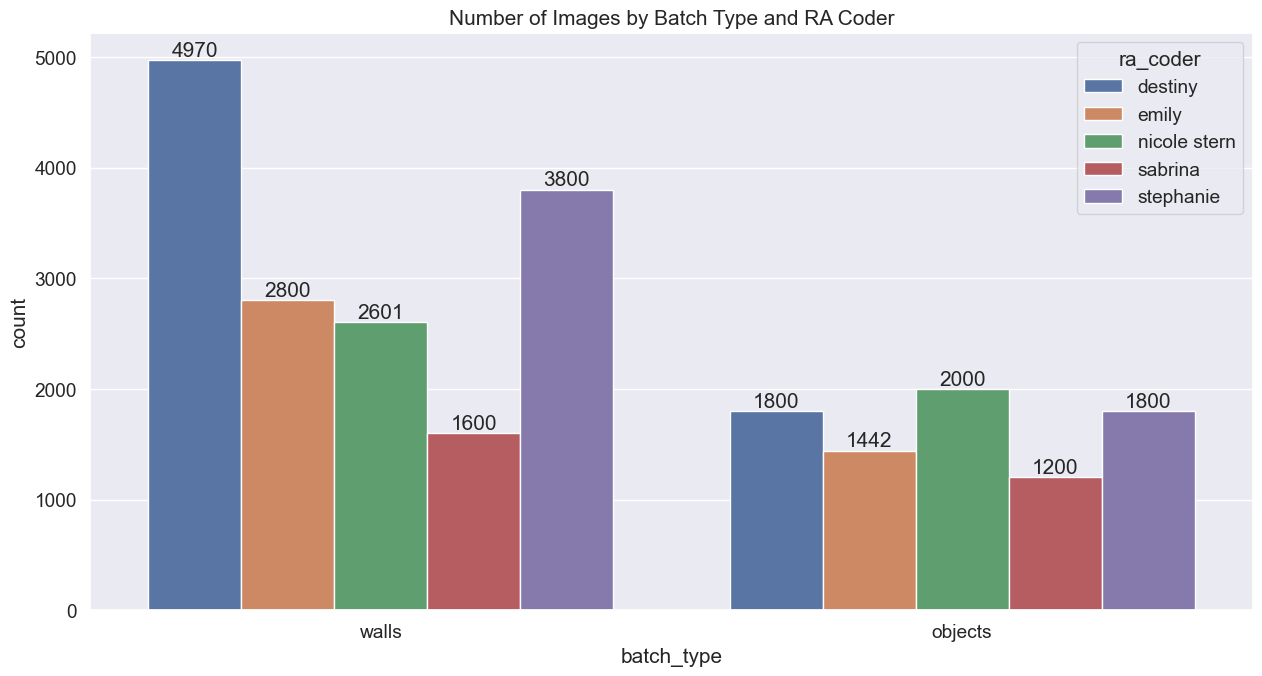

In [124]:
images_by_batch_type_and_ra_coder = sns.countplot(x="batch_type", hue="ra_coder", data=object_wall_hanging_df)
images_by_batch_type_and_ra_coder.set_title("Number of Images by Batch Type and RA Coder")

for p in images_by_batch_type_and_ra_coder.patches:
    height = p.get_height()
    images_by_batch_type_and_ra_coder.text(p.get_x() + p.get_width()/2., height,
            '{:d}'.format(int(height)), 
            ha="center", va="bottom")
    
figure = images_by_batch_type_and_ra_coder.get_figure()
figure.savefig("../object_wall_hanging_report/images_by_batch_type_and_ra_coder.png", bbox_inches="tight")

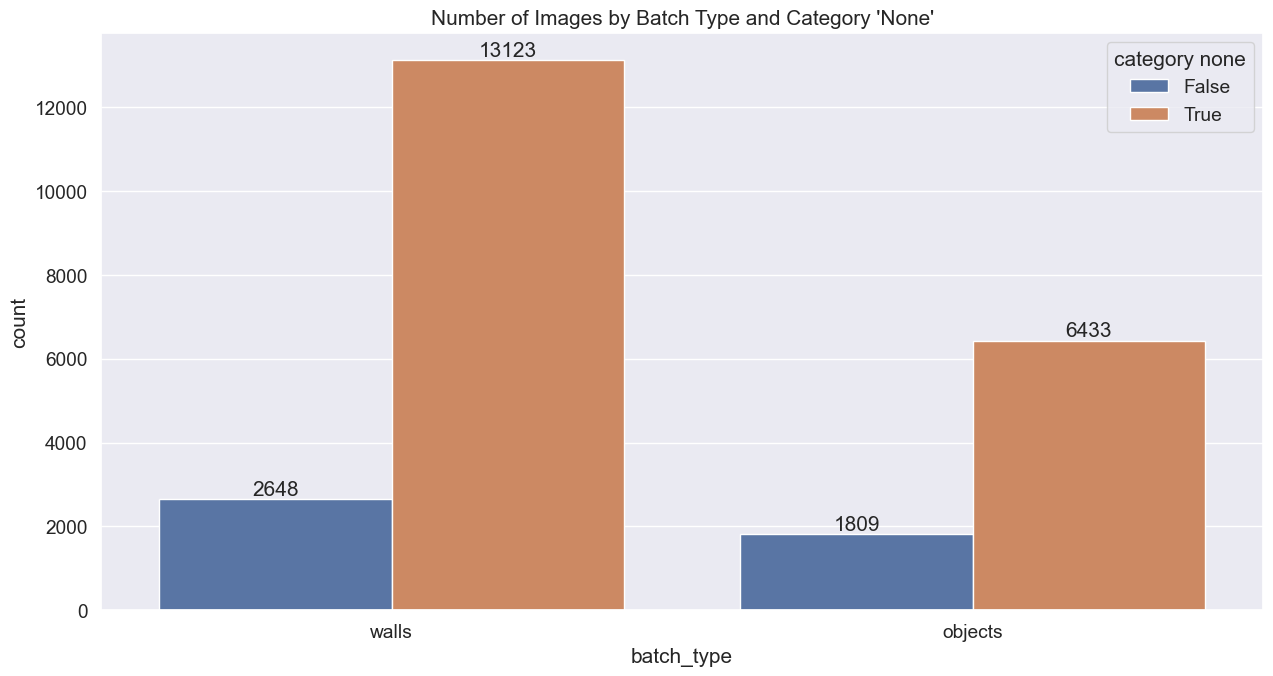

In [125]:
images_by_batch_type_and_category_none = sns.countplot(x="batch_type", hue="category none", data=object_wall_hanging_df)
images_by_batch_type_and_category_none.set_title("Number of Images by Batch Type and Category 'None'")

for p in images_by_batch_type_and_category_none.patches:
    height = p.get_height()
    images_by_batch_type_and_category_none.text(p.get_x() + p.get_width()/2., height,
            '{:d}'.format(int(height)), 
            ha="center", va="bottom")

figure = images_by_batch_type_and_category_none.get_figure()
figure.savefig("../object_wall_hanging_report/images_by_batch_type_and_category_none.png", bbox_inches="tight")

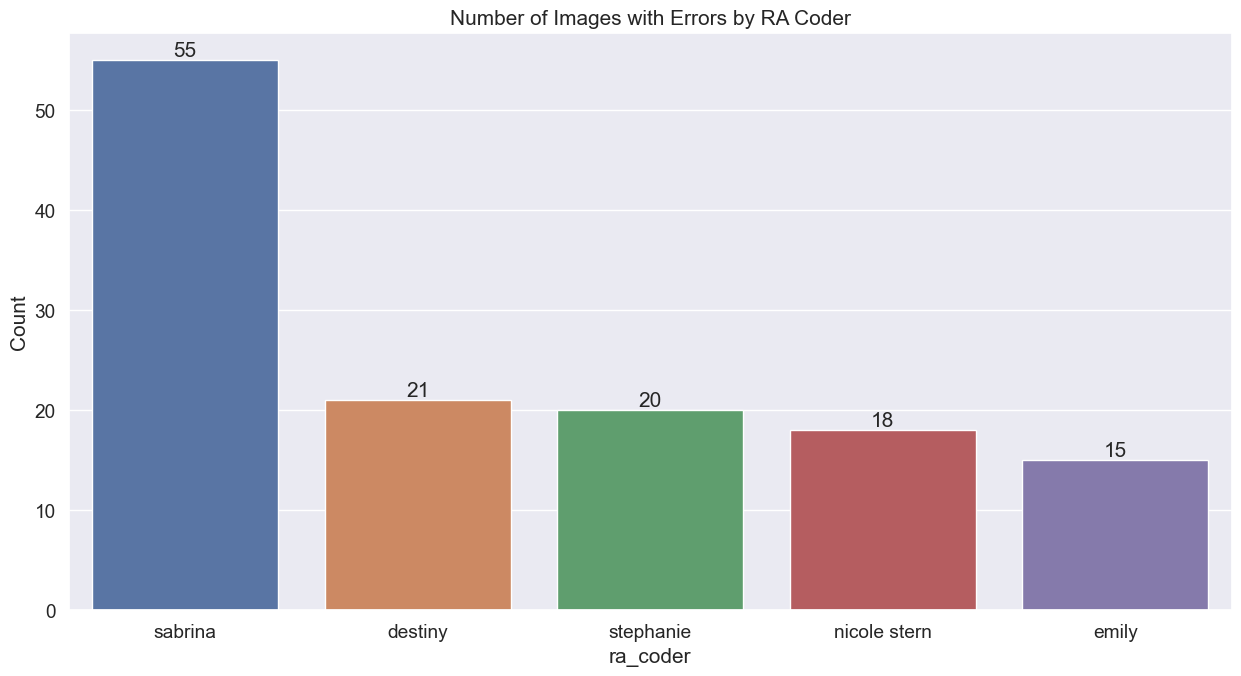

In [126]:
# display number of images with an error (i.e. error is not the empty string) by ra_coder
errors = object_wall_hanging_df[object_wall_hanging_df["error"] != ""]
num_errors = errors["ra_coder"].value_counts()
images_with_errors_by_ra_coder = sns.barplot(x=num_errors.index, y=num_errors.values)
images_with_errors_by_ra_coder.set_ylabel("Count")
images_with_errors_by_ra_coder.set_title("Number of Images with Errors by RA Coder")

for p in images_with_errors_by_ra_coder.patches:
    height = p.get_height()
    images_with_errors_by_ra_coder.text(p.get_x() + p.get_width()/2., height,
            '{:d}'.format(int(height)), 
            ha="center", va="bottom")

figure = images_with_errors_by_ra_coder.get_figure()
figure.savefig("../object_wall_hanging_report/images_with_errors_by_ra_coder.png", bbox_inches="tight")

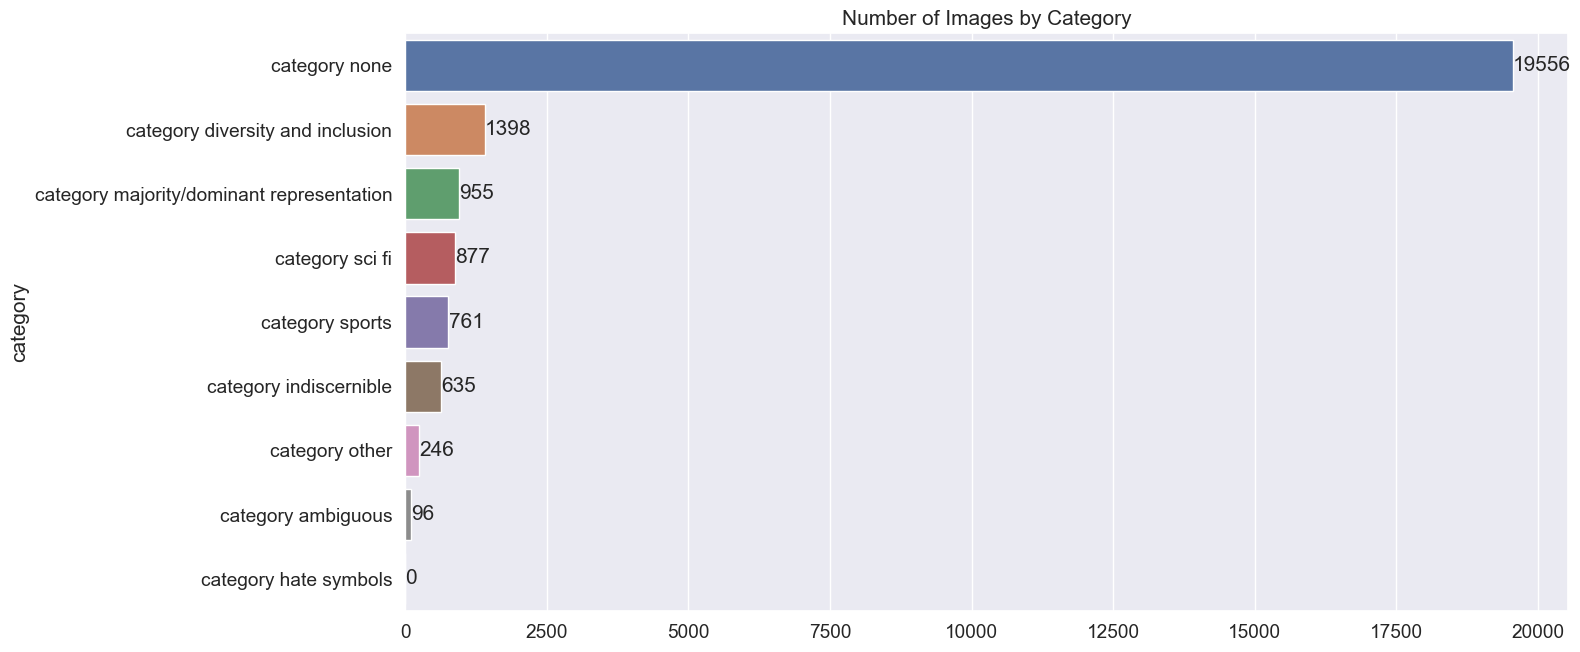

In [127]:
# show distribution among category
category_cols = [col for col in object_wall_hanging_df.columns if col.startswith("category")]
category_df = object_wall_hanging_df[category_cols]
category_df = category_df.melt(var_name="category", value_name="selected")
category_df = category_df[category_df["selected"] == True]
category_df_counts = category_df["category"].value_counts()

# add missing categories and set to 0
for category in category_information_with_prefix:
    if category not in category_df_counts.index:
        category_df_counts[category] = 0

images_by_category = sns.barplot(x=category_df_counts.values, y=category_df_counts.index)
images_by_category.set_title("Number of Images by Category")

for p in images_by_category.patches:
    width = p.get_width()
    images_by_category.text(width + 3, p.get_y() + p.get_height()/2.,
            '{:d}'.format(int(width)), 
            ha="left", va="center")

figure = images_by_category.get_figure()
figure.savefig("../object_wall_hanging_report/images_by_category.png", bbox_inches="tight")

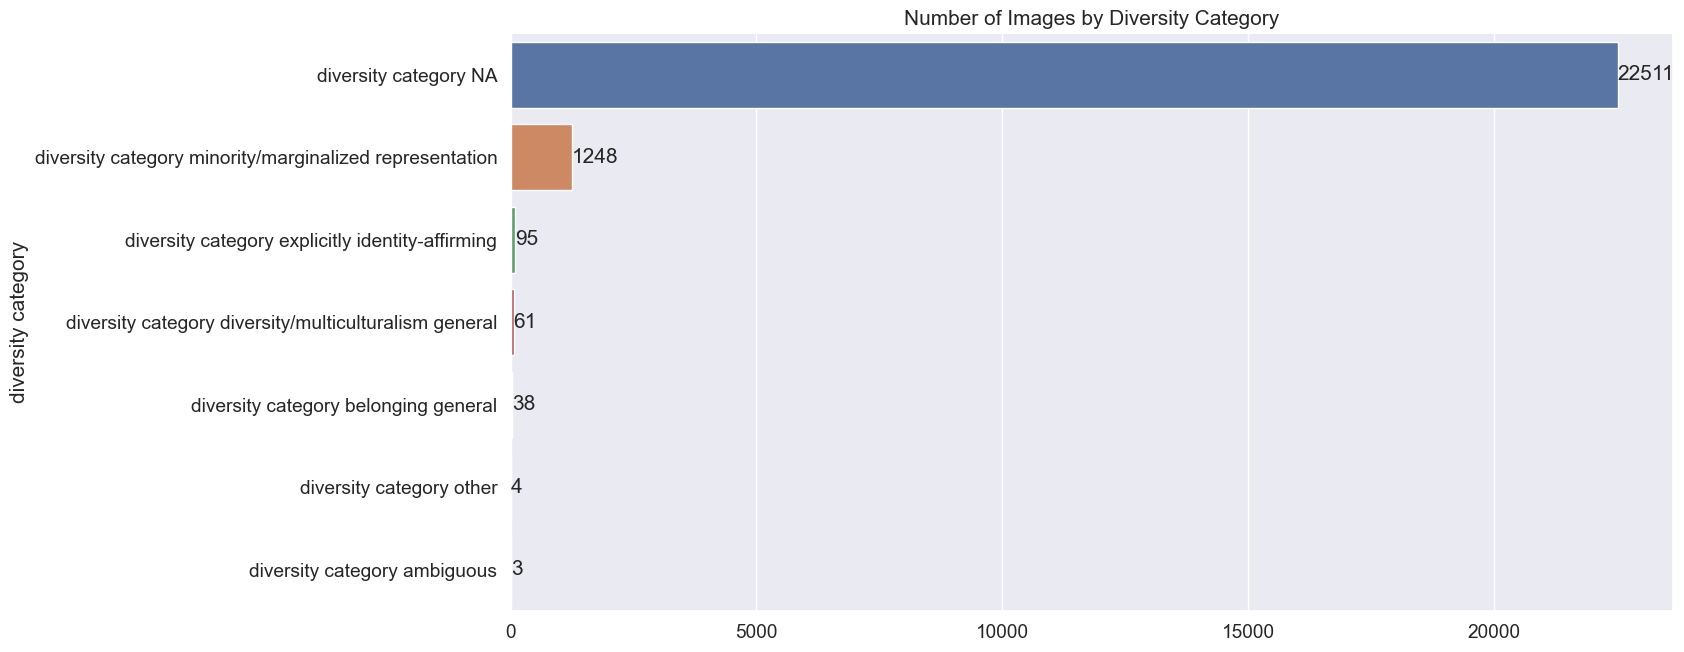

In [128]:
# show distribution among diversity_category
diversity_cols = [col for col in object_wall_hanging_df.columns if col.startswith("diversity category")]
diversity_df = object_wall_hanging_df[diversity_cols]
diversity_df = diversity_df.melt(var_name="diversity category", value_name="selected")
diversity_df = diversity_df[diversity_df["selected"] == True]
diversity_df_counts = diversity_df["diversity category"].value_counts()

# add missing categories and set to 0
for diversity_category in diversity_information_with_prefix:
    if diversity_category not in diversity_df_counts.index:
        diversity_df_counts[diversity_category] = 0

images_by_diversity_category = sns.barplot(x=diversity_df_counts.values, y=diversity_df_counts.index)
images_by_diversity_category.set_title("Number of Images by Diversity Category")

for p in images_by_diversity_category.patches:
    width = p.get_width()
    images_by_diversity_category.text(width + 3, p.get_y() + p.get_height()/2.,
            '{:d}'.format(int(width)), 
            ha="left", va="center")

figure = images_by_diversity_category.get_figure()
figure.savefig("../object_wall_hanging_report/images_by_diversity_category.png", bbox_inches="tight")

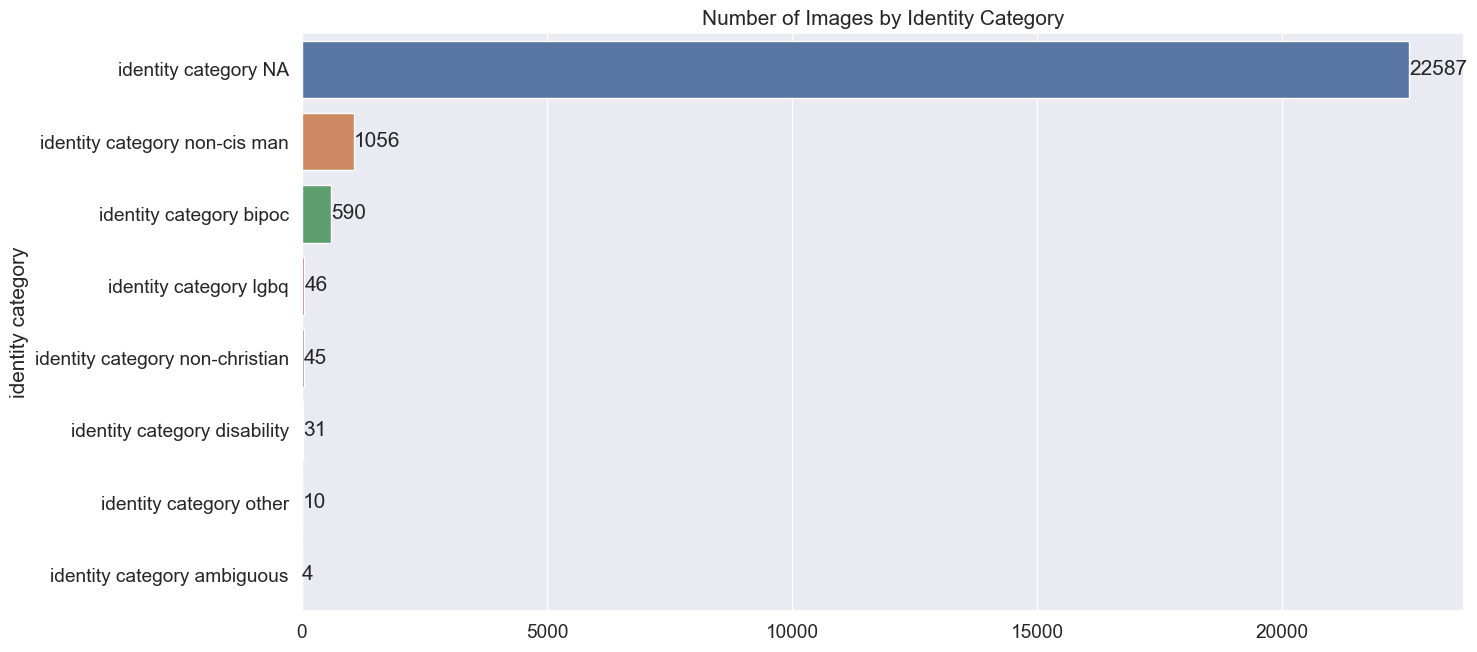

In [129]:
# show distribution among identity_category
identity_cols = [col for col in object_wall_hanging_df.columns if col.startswith("identity category")]
identity_df = object_wall_hanging_df[identity_cols]
identity_df = identity_df.melt(var_name="identity category", value_name="selected")
identity_df = identity_df[identity_df["selected"] == True]
identity_df_counts = identity_df["identity category"].value_counts()

# add missing categories and set to 0
for identity_category in identity_information_with_prefix:
    if identity_category not in identity_df_counts.index:
        identity_df_counts[identity_category] = 0

images_by_identity_category = sns.barplot(x=identity_df_counts.values, y=identity_df_counts.index)
images_by_identity_category.set_title("Number of Images by Identity Category")

for p in images_by_identity_category.patches:
    width = p.get_width()
    images_by_identity_category.text(width + 3, p.get_y() + p.get_height()/2.,
            '{:d}'.format(int(width)), 
            ha="left", va="center")

figure = images_by_identity_category.get_figure()
figure.savefig("../object_wall_hanging_report/images_by_identity_category.png", bbox_inches="tight")